In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42

### Load
df = pd.read_csv("/home/mouren/Data/valid_exp/summary_count_exonhancers_bilan.tsv", sep="\t", header=0)
df = df[~df['Log2FC'].str.contains('#', na=False)] # Remove rows with no log2FC values

df["Log2FC"] = df["Log2FC"].str.replace(',', '.')
df["Input_STD"] = df["Input_STD"].str.replace(',', '.')

df["Log2FC"] = pd.to_numeric(df["Log2FC"])
df["count_sequence_AVO4Exonhmaxi4"] = pd.to_numeric(df["count_sequence_AVO4Exonhmaxi4"])
df["Input_STD"] = pd.to_numeric(df["Input_STD"])

filtered_df = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) & (df['Input_STD'] <= 20) & (df['Category2'] == "EEK")]

df_sorted = filtered_df.sort_values(by='Log2FC', ascending=True).reset_index(drop=True)

### Colormap
# Determine the range
min_value = df_sorted['Log2FC'].min()
max_value = df_sorted['Log2FC'].max()
abs_max = max(abs(min_value), abs(max_value))# Set symmetric bounds around zero
norm = mcolors.TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)# Use TwoSlopeNorm with symmetric bounds # Change here if you want to adapt color graduation
cmap = cm.get_cmap('coolwarm')
###
df_sorted['Color'] = df_sorted['Log2FC'].apply(lambda x: mcolors.rgb2hex(cmap(norm(x))))
df_sorted['Name'] = df_sorted['ID'].apply(lambda x: '_'.join(x.split('_')[:3]))

df_no_snp = df_sorted[(df_sorted['Category2'] == "EEK")]

/tmp/ipykernel_246945/3428537447.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


In [ ]:
### Prepare volcano
## Compute SNP VS REF
#When log₂ fold changes are already available for both mutant and reference,
#the volcano‐plot x‐axis is just the difference (mutant log₂FC – reference log₂FC)
#Otherwise its x-axis = log2(FCmut/FCref)

nb_single_down = 0
nb_single_up = 0
nb_multi_down = 0
nb_multi_up = 0

filtered_df_snp = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) & (df['Input_STD'] <= 20) & ((df['Category2'] == "EESNP") | (df['Category2'] == "EEMULTISNP"))]
df_no_snp = df_sorted[(df_sorted['Category2'] == "EEK")]

snp_list_solo={}
snp_list_multi={}
with open("/home/mouren/Data/valid_exp/stat/all_starrseq_wald_FDR_pvalues.tsv") as file:
    for line in file:      
        if "EESNP" in line.strip().split("\t")[0]:       
            snp_list_solo[line.strip().split("\t")[0]] = float(line.strip().split("\t")[1])
        else:
            snp_list_multi[line.strip().split("\t")[0]] = float(line.strip().split("\t")[1])

content = [["Exon","Log2FC_diff°","-log10(FDR)","Color","SNP_FC","Type"]]
for key,val in snp_list_solo.items():
    matching_no_snp = df_no_snp.loc[df_no_snp['Name'] == '_'.join(key.split('_')[:3])]
    matching_wth_snp = filtered_df_snp.loc[filtered_df_snp['ID'] == key]
    res = matching_wth_snp["Log2FC"].iloc[0] - matching_no_snp["Log2FC"].iloc[0]
    if -np.log10(val) < 1.30:
        color = 'lightgrey'
    else:
        color = "green" 
        if res <0:
            nb_single_down+=1
        else:
            nb_single_up+=1
    content.append([key,res,-np.log10(val),color,matching_wth_snp["Log2FC"].iloc[0],"Single"])

for key,val in snp_list_multi.items():
    matching_no_snp = df_no_snp.loc[df_no_snp['Name'] == '_'.join(key.split('_')[:3])]
    matching_wth_snp = filtered_df_snp.loc[filtered_df_snp['ID'] == key]
    res = matching_wth_snp["Log2FC"].iloc[0] - matching_no_snp["Log2FC"].iloc[0]
    if -np.log10(val) < 1.30:
        color = 'lightgrey'
    else:
        color = "purple" 
        if res <0:
            nb_multi_down+=1
        else:
            nb_multi_up+=1
    content.append([key,res,-np.log10(val),color,matching_wth_snp["Log2FC"].iloc[0],"Multi"])

header = content[0]
rows = content[1:]
df_snps_vs_ref = pd.DataFrame(rows, columns=header)

df_snps_vs_ref_no_sig =df_snps_vs_ref[df_snps_vs_ref["Color"] == "lightgrey"]
df_snps_vs_ref_only_sig = df_snps_vs_ref[df_snps_vs_ref["Color"] != "lightgrey"]

df_snps_vs_ref_only_sig = df_snps_vs_ref_only_sig.sort_values(by=["Log2FC_diff°"], ascending=True) 

/tmp/ipykernel_246945/1753359048.py:29: RuntimeWarning: divide by zero encountered in log10
  if -np.log10(val) < 1.30:
/tmp/ipykernel_246945/1753359048.py:33: RuntimeWarning: divide by zero encountered in log10
  content.append([key,res,-np.log10(val),color,matching_wth_snp["Log2FC"].iloc[0],"Single"])
/tmp/ipykernel_246945/1753359048.py:39: RuntimeWarning: divide by zero encountered in log10
  if -np.log10(val) < 1.30:
/tmp/ipykernel_246945/1753359048.py:43: RuntimeWarning: divide by zero encountered in log10
  content.append([key,res,-np.log10(val),color,matching_wth_snp["Log2FC"].iloc[0],"Multi"])


In [3]:
### Prepare line plot
df_snp = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) & (df['Input_STD'] <= 20) & ((df['Category2'] == "EESNP") | (df['Category2'] == "EEMULTISNP"))]
content=[]
with open("/home/mouren/Data/valid_exp/stat/all_starr_snp_vs_ref_FDR_wald.tsv") as file:
    for line in file:  
        if float(line.strip().split()[1])<0.05:#we take only significative mutated seq           
            result_row = df_snp.loc[df_snp['ID'] == line.strip().split()[0]]
            if "EEMULTISNP" in line.strip().split()[0]:
                content.append(['_'.join(line.strip().split()[0].split('_')[:3]), result_row["Log2FC"].values[0], "MULTISNP"])
            else:
                content.append(['_'.join(line.strip().split()[0].split('_')[:3]), result_row["Log2FC"].values[0], "SNP"])

df_sig = pd.DataFrame(content)
df_sig['x'] = df_sig[0].apply(lambda val: df_sorted.index[df_sorted['Name'] == val].tolist()[0])

In [7]:
### Prepare line plot diff fc 
#dic of sequences ID matching
dic_matching = {}
with open("/home/mouren/Data/valid_exp/stat/seq_snp_ref_id.tsv") as f:
    for line in f:
        dic_matching[line.strip().split()[0]] = line.strip().split()[1]
        
snp_data = [["ID","diff_fc","ref_fc","ref_color","fabian_type_color","snp_type_color"]]
ref_data = [["ID","diff_fc","ref_fc","ref_color","fabian_type_color","snp_type_color"]]
with open("/home/mouren/Data/valid_exp/stat/all_starr_snp_vs_ref_FDR_wald.tsv") as file:
    for line in file:      
        if float(line.strip().split()[1])<0.05:#we take only significative mutated seq  
            ref_row = df_no_snp[df_no_snp['ID'] == dic_matching[line.strip().split()[0]]]
            snp_row = df_snp[df_snp['ID'] == line.strip().split()[0]]

            diff_fc = snp_row["Log2FC"].iloc[0] - ref_row["Log2FC"].iloc[0]
            
            ref_fc = ref_row["Log2FC"].iloc[0]
            ref_color = ref_row["Color"].iloc[0]

            fabian_type = (line.strip().split()[0].split("_")[-2])[0]
            if fabian_type == "L":
                fabian_type_color = "#0000FF"
            else:
                fabian_type_color = "#ff0000"

            if "EESNP" in line.strip().split("\t")[0]:       
                snp_type_color = "green"
            else:
                snp_type_color = "purple"

            snp_data.append([line.strip().split()[0],diff_fc,ref_fc,ref_color,fabian_type_color,snp_type_color])

df_plot = pd.DataFrame(snp_data)
df_plot.columns = df_plot.iloc[0]  # Set the first row as the header
df_plot = df_plot[1:].reset_index(drop=True)

##Duplicate ref x-axis
df_plot_sorted = df_plot.sort_values(by="diff_fc", ascending=False)
df_sorted_reset = df_plot_sorted.reset_index(drop=True)

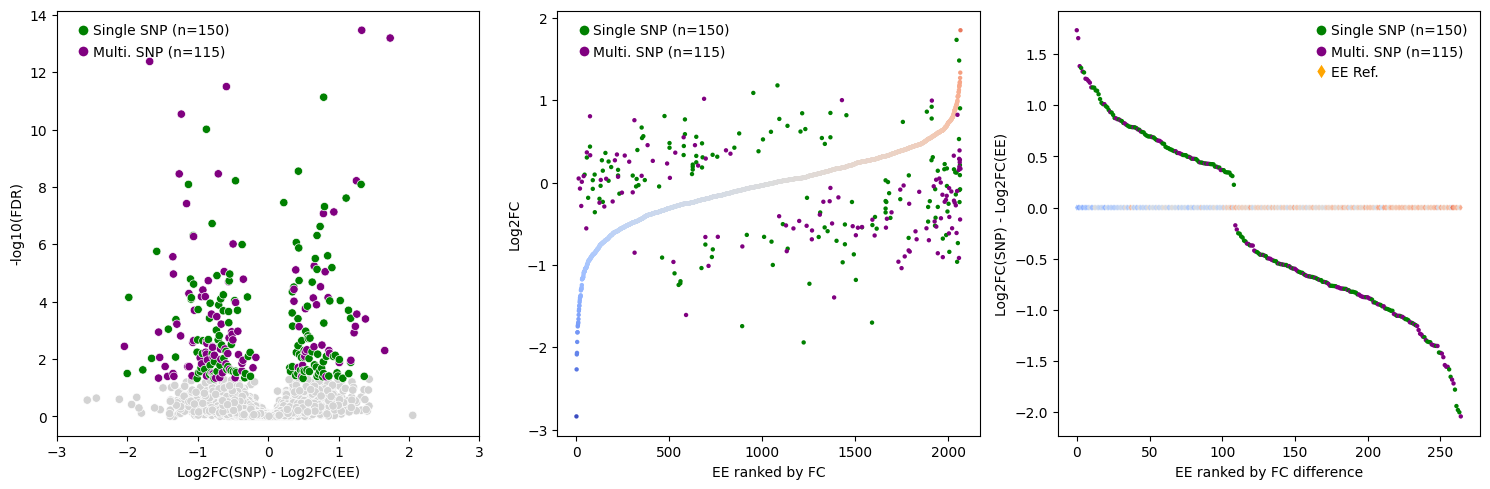

In [8]:
### PLOT
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Left volcano plot
sns.scatterplot(ax=axes[0], data=df_snps_vs_ref_no_sig, x='Log2FC_diff°', y='-log10(FDR)', c=df_snps_vs_ref_no_sig["Color"])
sns.scatterplot(ax=axes[0], data=df_snps_vs_ref_only_sig, x='Log2FC_diff°', y='-log10(FDR)', c=df_snps_vs_ref_only_sig["Color"])
axes[0].set_xlim(-3, 3)
axes[0].set_xlabel("Log2FC(SNP) - Log2FC(EE)")

# Middle line plot
sns.scatterplot(ax=axes[1], data=df_sorted, x=df_sorted.index, y=df_sorted['Log2FC'], c=df_sorted['Log2FC'], cmap='coolwarm', marker='o', s=10, edgecolor='none', norm=norm)
sns.scatterplot(ax=axes[1], data=df_sig, x=df_sig['x'], y=df_sig[1], s=10, edgecolor='none', hue=2,hue_order = ['SNP','MULTISNP'],palette = ['green','purple'])
axes[1].set_xlabel("EE ranked by FC")

# Right line plot #here the dot for the reference sequence is duplicated 
sns.scatterplot(ax=axes[2], data=df_sorted_reset, x=df_sorted_reset.index, y=df_plot_sorted["diff_fc"], marker='o', c=df_sorted_reset["snp_type_color"], s=10, edgecolor='none')
sns.scatterplot(ax=axes[2], data=df_sorted_reset, x=df_sorted_reset.index, y=([0] * len(df_sorted_reset.index)), c=df_sorted_reset["ref_color"], marker='d', s=10, edgecolor='none')
axes[2].set_xlabel("EE ranked by FC difference")
axes[2].set_ylabel("Log2FC(SNP) - Log2FC(EE)")

## Legend
from matplotlib.lines import Line2D
legend_entry = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Single SNP (n=150)'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='Multi. SNP (n=115)'),
                ]
axes[0].legend(handles=legend_entry, frameon=False, loc='upper left', bbox_to_anchor=(0, 1), handletextpad=-0.3)
axes[1].legend(handles=legend_entry, frameon=False, loc='upper left', bbox_to_anchor=(0, 1), handletextpad=-0.3)

legend_entry3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Single SNP (n=150)'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='Multi. SNP (n=115)'),
                Line2D([0], [0], marker='d', color='w', markerfacecolor='orange', markersize=8, label='EE Ref.'),
                ]
axes[2].legend(handles=legend_entry3, frameon=False, loc='upper right', bbox_to_anchor=(1, 1), handletextpad=-0.3)

plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/main_figures/fig4/starr_volcano_and_line_plots_fig4d.pdf", format="pdf", bbox_inches="tight")
plt.savefig("/home/mouren/Images/tls1/main_figures/fig4/starr_volcano_and_line_plots_fig4d.png", format="png", bbox_inches="tight")

plt.show()


In [4]:
### Prepare right line plot without ref duplicates 
filtered_df_snp = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) & (df['Input_STD'] <= 20) & ((df['Category2'] == "EESNP") | (df['Category2'] == "EEMULTISNP"))]
df_sorted['Name'] = df_sorted['ID'].apply(lambda x: '_'.join(x.split('_')[:3]))
df_no_snp = df_sorted[(df_sorted['Category2'] == "EEK")]

snp_list_solo=[]
snp_list_multi=[]
with open("/home/mouren/Data/valid_exp/stat/all_starr_snp_vs_ref_FDR_wald.tsv") as file:
    for line in file:   
        if float(line.strip().split()[1])<0.05:#we take only significative mutated seq     
            if "EESNP" in line.strip().split("\t")[0]:       
                snp_list_solo.append(line.strip().split("\t")[0])
            else:
                snp_list_multi.append(line.strip().split("\t")[0])

seq_no_snp = []
seq_wth_snp = {}
seq_wth_snp_color = {}
for i in snp_list_solo:
    matching_no_snp = df_no_snp.loc[df_no_snp['Name'] == '_'.join(i.split('_')[:3])]
    entry = [matching_no_snp["Name"].iloc[0],0,matching_no_snp["Color"].iloc[0]]
    if entry not in seq_no_snp:
        seq_no_snp.append(entry)
    
    matching_wth_snp = filtered_df_snp.loc[filtered_df_snp['ID'] == i]
    res = matching_wth_snp["Log2FC"].iloc[0] - matching_no_snp["Log2FC"].iloc[0]

    if '_'.join(i.split('_')[:3]) not in seq_wth_snp:
        seq_wth_snp['_'.join(i.split('_')[:3])] = [res]
    else:
        seq_wth_snp['_'.join(i.split('_')[:3])].append(res)

    snp_type = (i.split("_")[-2])[0]
    if snp_type == "L":
        res_color = "#0000FF"
    else:
        res_color = "#ff0000"
    if '_'.join(i.split('_')[:3]) not in seq_wth_snp_color:
        seq_wth_snp_color['_'.join(i.split('_')[:3])] = [res_color]
    else:
        seq_wth_snp_color['_'.join(i.split('_')[:3])].append(res_color)

max_length = max(len(lst) for lst in seq_wth_snp.values())
for key in seq_wth_snp:
    while len(seq_wth_snp[key]) < max_length:
        seq_wth_snp[key].append(np.nan)    
        seq_wth_snp_color[key].append(np.nan)
    
df_2 = pd.DataFrame(seq_wth_snp)
df_2 = df_2.T
df_2_color = pd.DataFrame(seq_wth_snp_color)
df_2_color = df_2_color.T
df_2_color.columns = [f"dfcolor_{col}" for col in df_2_color.columns]

df_combined = pd.concat([df_2, df_2_color], axis=1)
df_combined['dfcolor_1'].fillna("#000000", inplace=True)

#multi snp
seq_wth_snp = {}
for i in snp_list_multi:
    matching_no_snp = df_no_snp.loc[df_no_snp['Name'] == '_'.join(i.split('_')[:3])]
    entry = [matching_no_snp["Name"].iloc[0],0,matching_no_snp["Color"].iloc[0]]
    if entry not in seq_no_snp:
        seq_no_snp.append(entry)
    
    matching_wth_snp = filtered_df_snp.loc[filtered_df_snp['ID'] == i]
    res = matching_wth_snp["Log2FC"].iloc[0] - matching_no_snp["Log2FC"].iloc[0]
    if '_'.join(i.split('_')[:3]) not in seq_wth_snp:
        seq_wth_snp['_'.join(i.split('_')[:3])] = [res]
    else:
        seq_wth_snp['_'.join(i.split('_')[:3])].append(res)
    
# Pad the shorter lists with NaN values
max_length = max(len(lst) for lst in seq_wth_snp.values())
for key in seq_wth_snp:
    while len(seq_wth_snp[key]) < max_length:
        seq_wth_snp[key].append(np.nan)    
        seq_wth_snp_color[key].append(np.nan)

df_1 = pd.DataFrame(seq_no_snp)
df_1 = df_1.set_index(0)

df_3 = pd.DataFrame(seq_wth_snp)
df_3 = df_3.T

df_3["color_multi"] = "purple"
df_3 = df_3.rename(columns={0: 'multi'})

df_combined_all = pd.concat([df_combined, df_3], axis=1)

df_combined_all['new_col'] = df_combined_all[0].fillna(df_combined_all['multi'])

df_all_sorted = df_combined_all.sort_values(by="new_col", ascending=False)

df_1_reordered = df_1.reindex(df_all_sorted.index)


/tmp/ipykernel_16358/2283287587.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['dfcolor_1'].fillna("#000000", inplace=True)


/tmp/ipykernel_16358/618064295.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels([0,50,100,150,200])


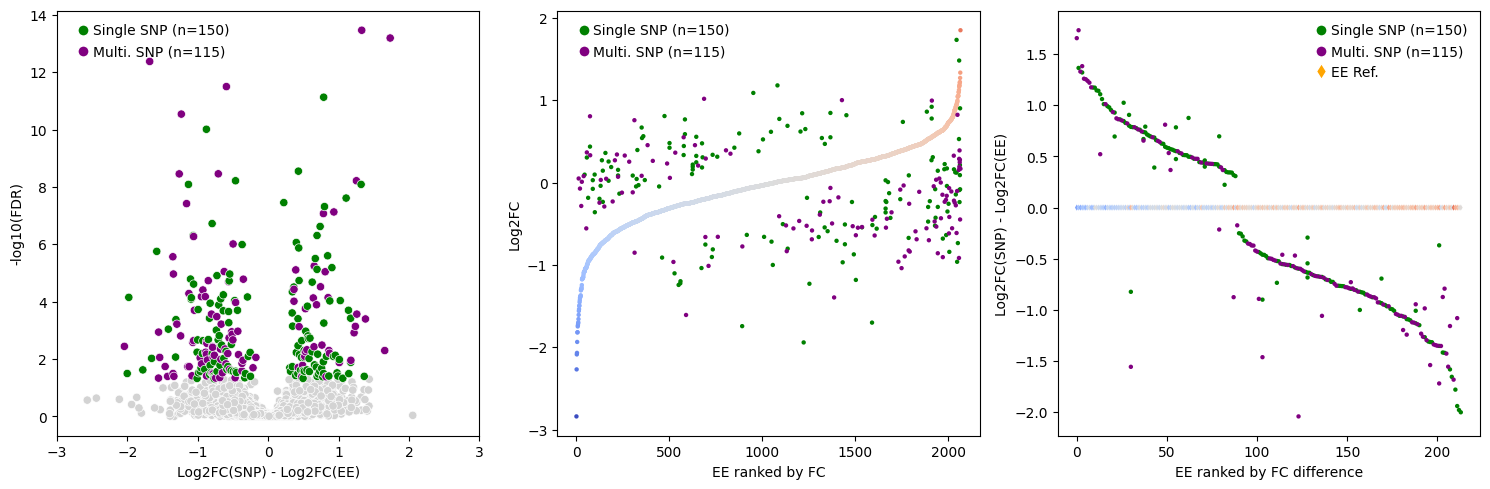

In [9]:
### PLOT WITH RIGHT LINE PLOT WITHOUR REF DUPLICATES 
### PLOT
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Left volcano plot
sns.scatterplot(ax=axes[0], data=df_snps_vs_ref_no_sig, x='Log2FC_diff°', y='-log10(FDR)', c=df_snps_vs_ref_no_sig["Color"])
sns.scatterplot(ax=axes[0], data=df_snps_vs_ref_only_sig, x='Log2FC_diff°', y='-log10(FDR)', c=df_snps_vs_ref_only_sig["Color"])
axes[0].set_xlim(-3, 3)
axes[0].set_xlabel("Log2FC(SNP) - Log2FC(EE)")

# Middle line plot
sns.scatterplot(ax=axes[1], data=df_sorted, x=df_sorted.index, y=df_sorted['Log2FC'], c=df_sorted['Log2FC'], cmap='coolwarm', marker='o', s=10, edgecolor='none', norm=norm)
sns.scatterplot(ax=axes[1], data=df_sig, x=df_sig['x'], y=df_sig[1], s=10, edgecolor='none', hue=2,hue_order = ['SNP','MULTISNP'],palette = ['green','purple'])
axes[1].set_xlabel("EE ranked by FC")

# Right line plot #here the dot for the reference sequence is NOT duplicated # The Ref sequence (ENST00000597436.5_cds_2) with the highest number of single snp associated sequence is 4 (plus one multi)
sns.scatterplot(ax=axes[2], data=df_1_reordered, x=df_1_reordered.index, y=df_1_reordered[1], c=df_1_reordered[2], marker='d', s=10, edgecolor='none') #Ref
sns.scatterplot(ax=axes[2], data=df_all_sorted, x=df_all_sorted.index, y=df_all_sorted[0], color="green", s=10, marker='o', edgecolor='none')
sns.scatterplot(ax=axes[2], data=df_all_sorted, x=df_all_sorted.index, y=df_all_sorted[1], color="green", s=10, marker='o',edgecolor='none')
sns.scatterplot(ax=axes[2], data=df_all_sorted, x=df_all_sorted.index, y=df_all_sorted[2], color="green", s=10, marker='o',edgecolor='none')
sns.scatterplot(ax=axes[2], data=df_all_sorted, x=df_all_sorted.index, y=df_all_sorted[3], color="green", s=10, marker='o',edgecolor='none')
sns.scatterplot(ax=axes[2], data=df_all_sorted, x=df_all_sorted.index, y=df_all_sorted["multi"], color="purple", s=10, marker='o',edgecolor='none')

axes[2].set_xticklabels([0,50,100,150,200])
axes[2].set_xticks([0,50,100,150,200])#214 rows
axes[2].set_xlabel("EE ranked by FC difference")
axes[2].set_ylabel("Log2FC(SNP) - Log2FC(EE)")

# Legend
## Legend
from matplotlib.lines import Line2D
legend_entry = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Single SNP (n=150)'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='Multi. SNP (n=115)'),
                ]
axes[0].legend(handles=legend_entry, frameon=False, loc='upper left', bbox_to_anchor=(0, 1), handletextpad=-0.3)
axes[1].legend(handles=legend_entry, frameon=False, loc='upper left', bbox_to_anchor=(0, 1), handletextpad=-0.3)

legend_entry3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Single SNP (n=150)'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='Multi. SNP (n=115)'),
                Line2D([0], [0], marker='d', color='w', markerfacecolor='orange', markersize=8, label='EE Ref.'),
                ]
axes[2].legend(handles=legend_entry3, frameon=False, loc='upper right', bbox_to_anchor=(1, 1), handletextpad=-0.3)

plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/main_figures/fig4/starr_volcano_and_line_plots_fig4d_no_duplicates.pdf", format="pdf", bbox_inches="tight")
plt.savefig("/home/mouren/Images/tls1/main_figures/fig4/starr_volcano_and_line_plots_fig4d_no_duplicates.png", format="png", bbox_inches="tight")

plt.show()

